- Self attention demo based on youtube video:
  - https://www.youtube.com/watch?v=FepOyFtYQ6I
  - added explanations and detailed notes and masking

# **Introduction**

How do humans store and express knowledge? One method is to use language. We use about 2,000 words in our active vocabulary (i.e., in everyday parlance) but the overall vocabulary of an average adult is about 30,000 words. Researchers have proposed that we acquire this vocabulary through reading, and that the bulk of knowledge acquition happens as we ingest and learn from the texts we read.

This idea was tested out at scale first by researchers at Google who came up with a unique architecture (called the *Transformer*) that was able to ingest large amounts of text in one batch and synthesize this text into a numeric representation. What is particularly interesting is that Open AI then deployed this compute efficient architecture to solve a delightfully simple problem called *language modeling* (see figure below): given an input text of certain fixed length, can we predict the next word that completes this input text? Neither was language modeling objective novel nor was the model architecture. The genius was in using the architecture to achieve the language modeling objective.

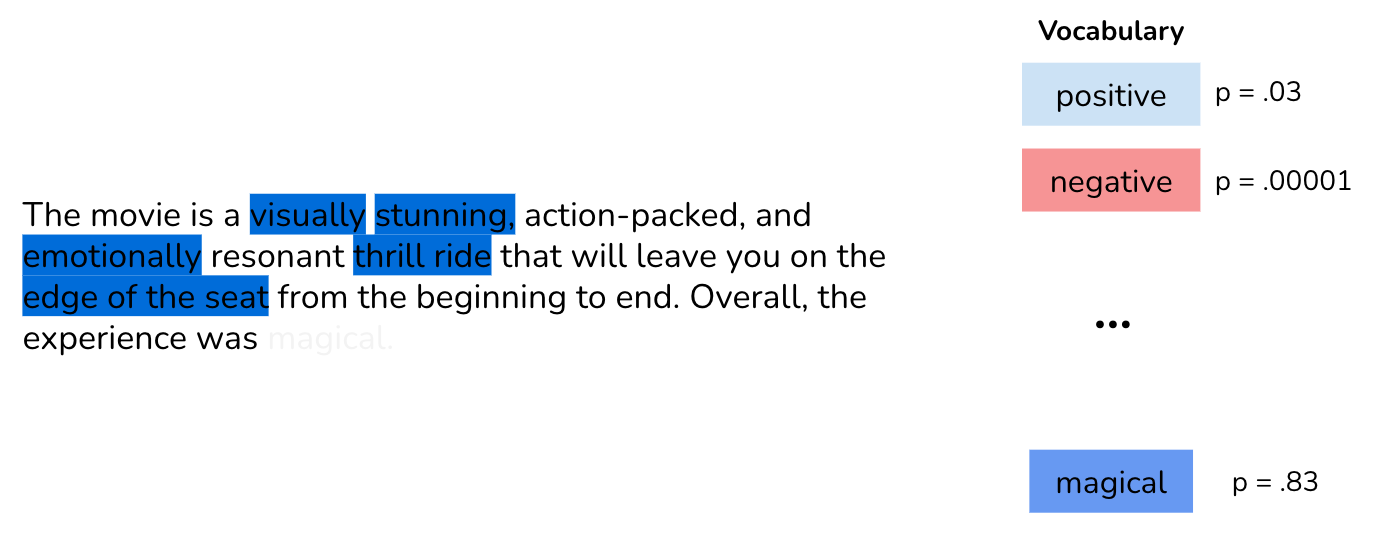

This series of experiments kicked off the GPT-series ane eventually to the GPT-3.5 model that captured the imagination of millions of users through its intuitive interface - ChatGPT. Open AI popularized the idea of *pretraining* where a numeric representation of sentences is learned by processing very large amounts of text using a transformer architecture.

In this notebook, we take a close look at the central workhorse of GPT-style models: the concept of self-attention.

## The architecture of GPT-style models

The original transformer architecture (see figure below) was proposed for language translation in 2017 by researchers at Google.

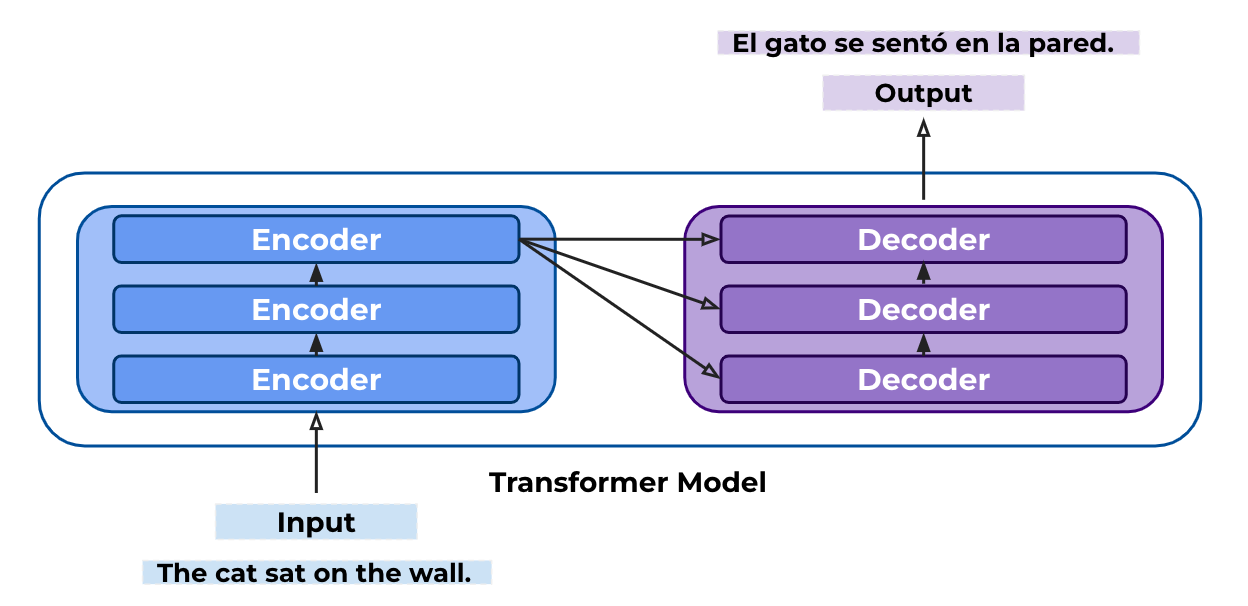

As the above figure indicates, the transformer ingests the input sentence in one go and encodes a numeric representation of this input using a series of encoder blocks. This numeric representation is then passed over to a series of decoder blocks that *generate* a translated output word-by-word.

The unique aspect of this architecture is the way the encoding and the decoding work. During encoding, all the words in the input sentence are processed at once. However, while decoding, the model is only allowed to look at the words that is has already predicted to make a new prediction. That is, the decoder blocks can only look at the history.

This aspect of decoder blocks is what makes them valuable from a generation perspective. They can look at a piece of text in its current state and predict what is an ideal word that can be appended to this text.

In sum, transformers can be thought of a mapping from an input sequence (say, a sentence in English) to an output sequence (say, the translation to French).

## GPT-style transformers

GPT-style transformers popularized by Open AI and the current generative AI revolution use only the decoder portion of the original transformer architecture during training and inference.


## Self-Attention

An important innovation of the transformer architecture was *self-attention* that allows the network to extract and use information from an arbitrarily large context window (as allowed by the compute infrastructure). The self-attention mechanism maps a tuple of input sequences $(\mathbf{q_1}, \mathbf{q_2}, \ldots, \mathbf{q_n})$ to a tuple of output sequences $(\mathbf{v_1}, \mathbf{v_2}, \ldots, \mathbf{v_n})$. Note that both the input and output are of the same length. Each word in the input sequence is associated with a vector of length $d_{in}$ that is then modified into a contextualized input sequence. After self-attention is applied, each word in the output sequence is then associated with a vector of length $d_{out}$.

Through self-attention, each word in the sequence becomes aware of the other words in the sequence. We will look at how exactly this "contextualization" is formalized shortly.

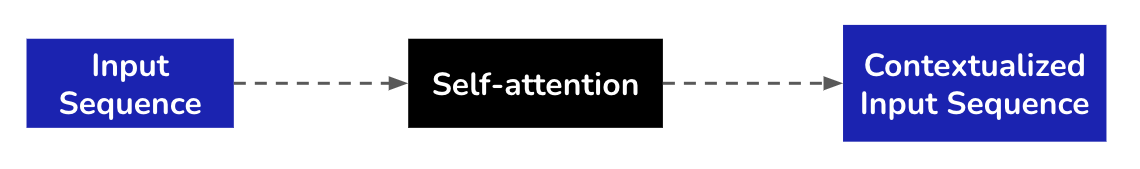

ote that we restrict sequences to a fixed length of $n$ that is referred to as context length. If inputs are lesser than the context length, they are padded. If the inputs are larger than the context length, they are chopped.   

## Arranging data for self-attention

The first step in formalization of the computation of contextual representations using self-attention is to understand how training data is prepared to learn these representations. For example, consider the sequences we ran inference earlier on:

**Sequence 1:** `<s> formal algorithms for transformers <\s>`

**Sequence 2:** `<s> normal algorithms for transformers <\s>`

During training (and hence during inference), this is batch of 2 sequences is converted to multiple sequences like so.

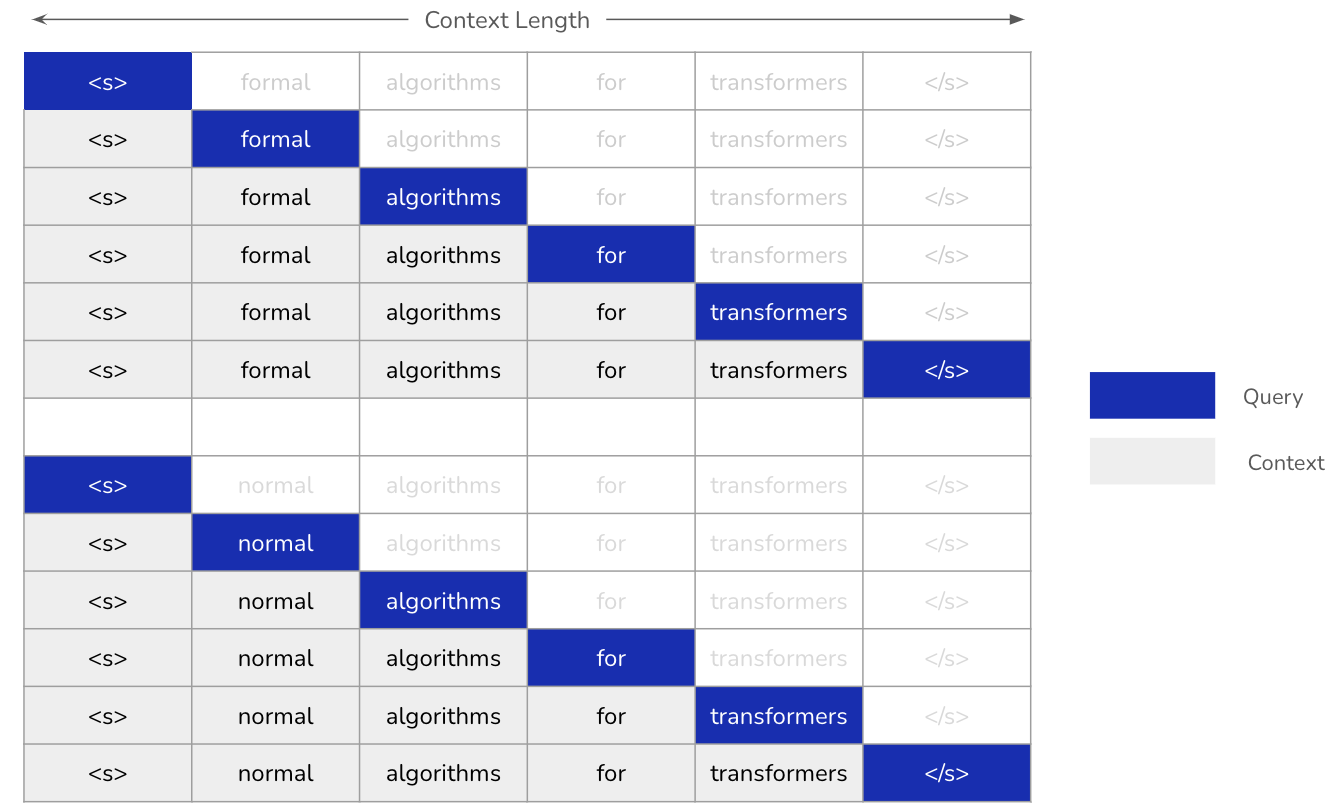

Notice how we create 6 (= context length) copies of each sentence and in each copy one of the words acts as the query, that is, the word we are trying to contextualize. We do so by allowing this query to interact with the context words. In a sense, this replication parallelizes the interaction of the context words with the query words.

However, at any point, we are not allowed to look at the future words. Note that the 6 copies are not strictly independent of each other, but we treat them as if they were. This method allows us to convert large amounts of unlabeled data into pairs of context - query, hence bringing the problem of next word prediction to a supervised learning realm.


While this method of arranging data allows us to scale training massively, it still leaves two problems unanswered:
1. How do we predict the query word accounting for all the context words before it? In other words, what specific method do we use to contextualize the query given the context?
2. How do we ensure that our computational mechanism forbids queries looking at future words (given that they exist in the copies)?

## What is (single-query) self-attention?

Attention tackles the problem of contextualizing a specific query within the context of the other words in the input sequence. In self-attention the query is contextualized using the other words in the same sequence. As the figure above indicates, during training words in the input take turns to play the role of a query in the duplicated samples and the rest of the words play the role of context words.

But how does this contextualization translate to mathematically?

In the sentence: 'formal algorithms for transformers', consider a query word (say 'algorithms') represented by the vector $\mathbf{q}$  and the context word (say 'formal') represented by the vector $\mathbf{k}$. If the word 'formal' is close to 'algorithms' semantically, then the vectors $\mathbf{q}$ and $\mathbf{k}$ would be close to each other. One way to mathematically express this similarity is to use the dot product $\mathbf{q}\mathbf{k}^T$.

Let us consider this as the score associated with the query-context word pair:

$$
\text{score}(\mathbf{q}, \mathbf{k}) = \mathbf{q}\mathbf{k}^T
$$

We can roll out this computation for all the context words in the input and compute a weight ($\alpha_c$) attached to this specific context word ('for') using a softmax like so:
$$
\alpha_{c} = \text{softmax}(\text{score}(\mathbf{q}, \mathbf{k}))
= \dfrac{\text{exp}(\text{score}(\mathbf{q}, \mathbf{k}))}{\sum\text{exp}(\text{score}(\mathbf{q}, \mathbf{k}))}
$$

Here, $\alpha_c$ refers to the weightage associated to the context word (in this case, 'for') normalized using all the other context word scores. We will call these *attention weights* since they capture the relative importance (or attention) that the query needs to pay to each word in the context.

As a last step, we will need to embed this computation into a learnable mechanism that will push semantically close words closer to each other during training for last word prediction. We achieve this using the query-key-value formulation like so:

- A word (represented by a $d_{in}$ dimension vector $\mathbf{x}$) that we are currently focusing on (e.g., 'algorithms') is called the *query* and is associated a vector $\mathbf{q} = \mathbf{W_q} \mathbf{x} + \mathbf{b_q}$. Here $\mathbf{W_q}$ is of dimension $d_{attn} \times d_{in}$. This ensures that the input query $\mathbf{x}$ is pushed to an attention space with dimension $d_{attn}$. For example, Mistral and Llama2 have $d_{attn} = 4096$.
- All the preceding context words (e.g., 'formal') are referred to as *keys* (represented by a $d_{in}$ dimension vector $\mathbf{x'}$) and are associated with vectors $\mathbf{k_c} = \mathbf{W_k} \mathbf{x'} + \mathbf{b_k}$. Here $\mathbf{W_k}$ is of dimension $d_{attn} \times d_{in}$. This ensures that keys in the context are also pushed to an attention space with dimension $d_{attn}$.
- With queries and keys in a (learnable) attention space, we can collect the attentions weights for each of the keys as: $\alpha_c = \text{softmax}(\text{score}(\mathbf{q}, \mathbf{k_c}))$. Note that $\alpha_c$'s are scalars.
- As the final step of the contextualization, each key vector is projected into an output space as a *value* vector $\mathbf{v_c} = \mathbf{W_v} \mathbf{x'} + \mathbf{b_v}$, where $\mathbf{W_v}$ is of dimension $d_{out} \times d_{in}$. Now, for the input query $\mathbf{q}$ we return its contextualized representation as the vector $\mathbf{\tilde{v}} = \sum \alpha_c\mathbf{v_c}$.

The contextualization is complete since each of the context words has a say in the representation of the query (just like a weighted average).

During the training process, we learn the following weight matrices:
- $\mathbf{W_q}$ of dimension $d_{in} \times d_{attn}$
- $\mathbf{W_k}$ of dimension $d_{in} \times d_{attn}$
- $\mathbf{W_v}$ of dimension $d_{out} \times d_{in}$

Example: Mistral architecture

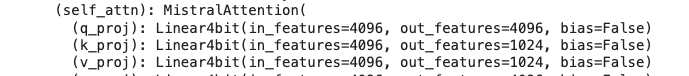

Notice that there is no sense of position in the attention mechanism we discussed so far. We still have to enforce a computationally efficient mechanism that masks out future context words when a query is attending to the context using this mechanism. This **requires a simple masking trick**

Let us zoom into the $\mathbf{q}\mathbf{k}^T$ computation above where we apply a mask. Note that the mask is applied in the forward pass and the original $\mathbf{q}\mathbf{k}^T$ scores are replaced with $-\infty$ under the masking condition. Since we have a softmax applied in the next step, this is equivalent to zeroing out the attention scores to the positions where attention should not be paid to. This mechanism is depicted below.

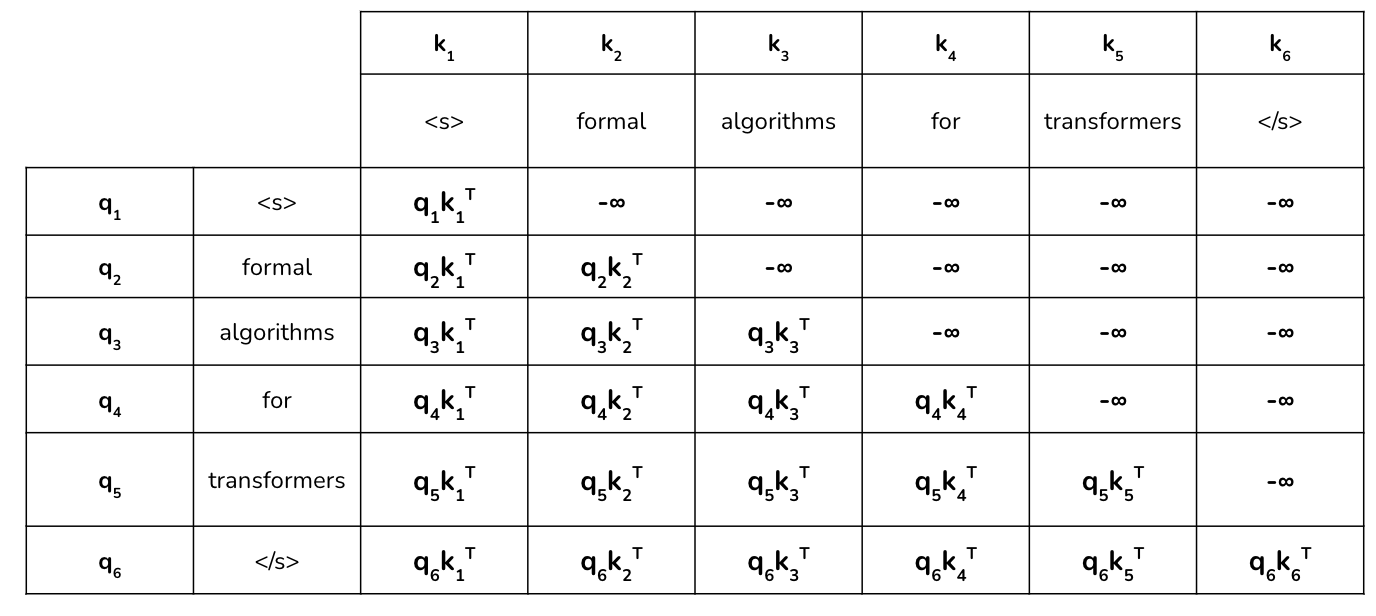

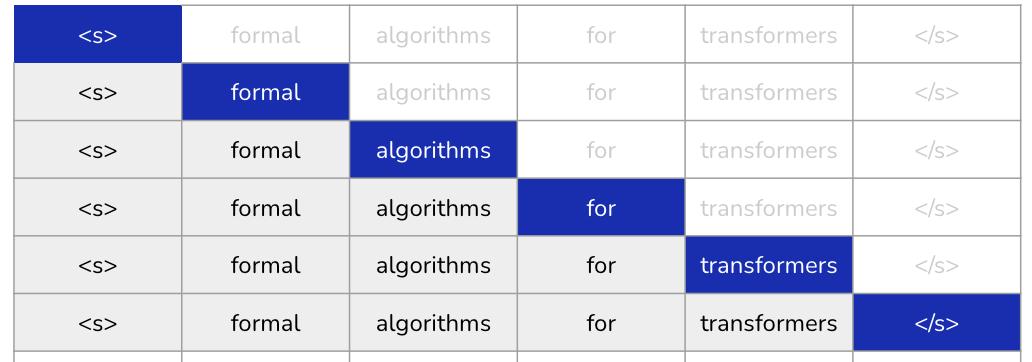

# Example Demo of Self-Attention

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import rich
from rich import print

# Create Embeddings

**We are just arbitarily creating vectors to demonstrate the embedding**


In [100]:
# Set a random seed, so we get the same values on every run
torch.manual_seed(42)

In [101]:
batch_size = 1
context_length = 8  # number of words in sentence
token_dimensions = 5    # number of tokens associated with each word in sentence
input_text = "The narrator lightly suggested to like and subscribe"

x = torch.randn(batch_size, context_length, token_dimensions)



In [102]:
print(f"[bold]The input text is:[/bold]\n{input_text}\n")
print(f"[bold]The number of words in the input text is:[/bold]\n{len(input_text.split())}\n")
print(f"[bold]The input text is tokenized and randomly embedded as such:[/bold]\n- Each Row is a word in the sentence\n- Each word in this case has [bold]embedding dimension of 5[/bold]")
print(f"- The batch size represents the number of independent input sequences (or sentences) being processed simultaneously.\n\n {x}")

The input text is:
The narrator lightly suggested to like and subscribe

The number of words in the input text is:
8

The input text is tokenized and randomly embedded as such:
- Each Row is a word in the sentence
- Each word in this case has embedding dimension of 5

- The batch size represents the number of independent input sequences (or sentences) being processed 
simultaneously.

 tensor([[[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784],
         [-1.2345, -0.0431, -1.6047, -0.7521,  1.6487],
         [-0.3925, -1.4036, -0.7279, -0.5594, -0.7688],
         [ 0.7624,  1.6423, -0.1596, -0.4974,  0.4396],
         [-0.7581,  1.0783,  0.8008,  1.6806,  0.0349],
         [ 0.3211,  1.5736, -0.8455,  1.3123,  0.6872],
         [-1.0892, -0.3553, -1.4181,  0.8963,  0.0499],
         [ 2.2667,  1.1790, -0.4345, -1.3864, -1.2862]]])

**Below are some commonly used embedding models, notice the Embedding Dimensions**

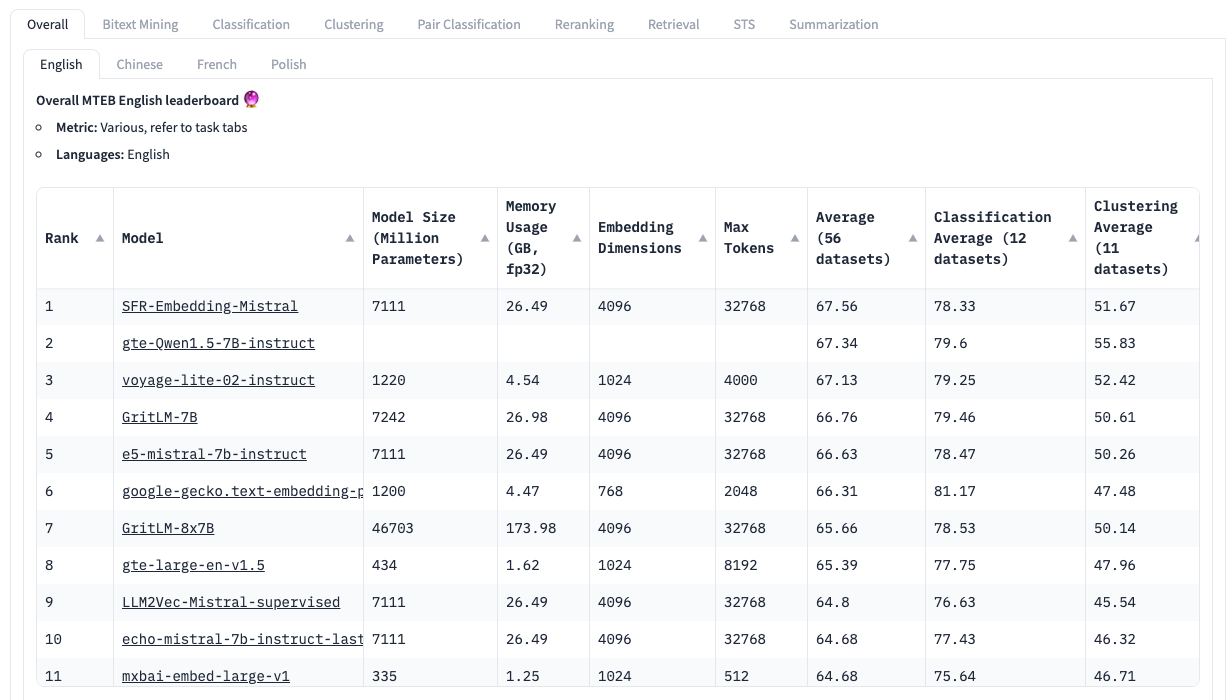

In [66]:
x.shape # x is our embedded sentence

torch.Size([1, 8, 5])

# Initialize Q/K/V Matrices

In [107]:
# Set a random seed
torch.manual_seed(42)

In [108]:
weight_dimensions = 4
W_query = torch.randn(token_dimensions, weight_dimensions)
W_key = torch.randn(token_dimensions, weight_dimensions)
W_value = torch.randn(token_dimensions, weight_dimensions)
print(f"W_query: \n{W_query}")
print(f"W_key: \n{W_key}")
print(f"W_value: \n{W_value}")

W_query: 
tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
        [-0.7581,  1.0783,  0.8008,  1.6806],
        [ 0.3559, -0.6866, -0.4934,  0.2415],
        [-0.2316,  0.0418, -0.2516,  0.8599],
        [-0.3097, -0.3957,  0.8034, -0.6216]])

W_key: 
tensor([[ 0.3189, -0.4245,  0.3057, -0.7746],
        [-0.8371, -0.9224,  1.8113,  0.1606],
        [ 0.3672,  0.1754,  1.3852, -0.4459],
        [-1.2024,  0.7078, -1.0759,  0.5357],
        [ 1.1754,  0.5612, -0.4527, -0.7718]])

W_value: 
tensor([[ 0.1453,  0.2311,  0.0087, -0.1423],
        [ 0.4048, -1.3543, -0.4976,  0.4747],
        [-2.5095,  0.4880,  0.7846,  0.0286],
        [ 1.7423, -1.3527,  0.2191,  0.5526],
        [-0.1853,  0.7528,  0.4048,  0.1785]])

In [109]:
# printing the shapes
print(f"W_query shape: {W_query.shape}")
print(f"W_key shape: {W_key.shape}")
print(f"W_value shape: {W_value.shape}")

W_query shape: torch.Size([5, 4])

W_key shape: torch.Size([5, 4])

W_value shape: torch.Size([5, 4])

# 1. Compute Attention Scores

In [110]:
Q = x @ W_query # all the query vectors, multiplying by the Weight of the query vector (matmul)
K = x @ W_key
V = x @ W_value

In [111]:
print(f"Note that we are multiplying a 8X5 matrix with 5X4 matrix\nThis gives us a 8X4 matrix for each of Q/K/V\nThis means that each word now has 4 weights for Q/K/V\n")
print(f"Q (query vectors): \n{Q}\nShape:{Q.shape}\n")
print(f"K (key vectors): \n{K}\nShape:{K.shape}\n")
print(f"V (value vectors): \n{V}\nShape:{V.shape}\n")

Note that we are multiplying a 8X5 matrix with 5X4 matrix
This gives us a 8X4 matrix for each of Q/K/V
This means that each word now has 4 weights for Q/K/V

Q (query vectors): 
tensor([[[ 3.1835,  3.4948,  3.5570, -3.5722],
         [-3.2537, -1.4646,  1.1590,  0.4679],
         [ 0.4165, -1.3166, -1.5954, -1.7115],
         [ 0.1463,  2.8198,  2.5590,  0.4153],
         [-2.3935, -0.4583, -0.6092,  5.0253],
         [-1.3919,  2.5378,  2.1884,  2.4656],
         [-2.5571, -1.0117, -0.7513,  2.0934],
         [ 4.0389,  5.3919,  2.5155, -3.2887]]])
Shape:torch.Size([1, 8, 4])

K (key vectors): 
tensor([[[ 3.0294, -3.1415,  6.4888, -3.3068],
         [ 1.8953,  0.6752, -2.6154, -0.0105],
         [ 0.5515,  0.5062, -2.7206,  0.6969],
         [-0.0755, -1.9719,  3.3229, -0.8614],
         [-2.8302,  0.6768,  1.0067,  1.2766],
         [-2.2957, -0.4216,  0.0543,  0.5535],
         [-1.5897,  1.2037, -3.9276,  1.8604],
         [-0.2684, -3.8290,  4.3006, -1.1227]]])
Shape:torch.Size([1, 8, 4])

V (value vectors): 
tensor([[[-5.1723,  2.2292, -0.2034, -0.5849],
         [ 2.2143,  1.2485, -0.7457, -0.0122],
         [ 0.3692,  1.6331, -0.3097, -1.0776],
         [ 0.2281, -1.1223, -0.8669,  0.4701],
         [ 1.2383, -3.4918,  0.4674,  1.5777],
         [ 4.9645, -3.7275, -0.8781,  1.5249],
         [ 4.8088, -1.6373, -0.7287,  0.4499],
         [-0.2801, -0.3779, -1.7323, -0.7711]]])
Shape:torch.Size([1, 8, 4])

In [112]:
print(f"K.transpose(-2, -1) changes the shape of K from [1, 8, 4] to [1, 4, 8].\nThis is required so we can do matrix multiplication of Q and K.transpose(-2, -1)\n")
print(f"K.transpose(-2, -1): \n{K.transpose(-2, -1)}\nShape:{K.transpose(-2, -1).shape}\n")


K.transpose(-2, -1) changes the shape of K from [1, 8, 4] to [1, 4, 8].
This is required so we can do matrix multiplication of Q and K.transpose(-2, -1)

K.transpose(-2, -1): 
tensor([[[ 3.0294,  1.8953,  0.5515, -0.0755, -2.8302, -2.2957, -1.5897,
          -0.2684],
         [-3.1415,  0.6752,  0.5062, -1.9719,  0.6768, -0.4216,  1.2037,
          -3.8290],
         [ 6.4888, -2.6154, -2.7206,  3.3229,  1.0067,  0.0543, -3.9276,
           4.3006],
         [-3.3068, -0.0105,  0.6969, -0.8614,  1.2766,  0.5535,  1.8604,
          -1.1227]]])
Shape:torch.Size([1, 4, 8])

**matmul for query and Key**

In [114]:
# Compute the dot product
scores = Q @ K.transpose(-2, -1)
print(f"Q @ K.transpose(-2, -1): \n\n{scores}\n\nShape:{scores.shape}\n\n")
print("Note: Q @ K.transpose(-2, -1) gives a 8X8 matrix, since Q was 8X4 and K.transpose(-2, -1) was 4X8\n")


Q @ K.transpose(-2, -1): 

tensor([[[ 3.3559e+01, -8.7184e-01, -8.6418e+00,  7.7649e+00, -7.6242e+00,
          -1.0566e+01, -2.1471e+01,  5.0716e+00],
         [ 7.1781e-01, -1.0192e+01, -5.3631e+00,  6.5821e+00,  9.9813e+00,
           8.4090e+00, -2.7220e-01,  1.0940e+01],
         [ 7.0522e-01,  4.0911e+00,  2.7110e+00, -1.2622e+00, -5.8609e+00,
          -1.4351e+00,  8.3495e-01, -9.9974e-03],
         [ 6.8164e+00, -4.5158e+00, -5.1645e+00,  2.5741e+00,  4.6006e+00,
          -1.1559e+00, -6.1164e+00, -2.9753e-01],
         [-2.6381e+01, -3.3055e+00,  3.6073e+00, -5.2687e+00,  1.2266e+01,
           8.4363e+00,  1.4995e+01, -5.8646e+00],
         [-6.1422e+00, -6.6742e+00, -3.7187e+00,  2.4872e-01,  1.1008e+01,
           3.6092e+00,  1.2595e+00, -2.7006e+00],
         [-1.6366e+01, -3.5866e+00,  1.5805e+00, -2.1118e+00,  8.4684e+00,
           7.4147e+00,  9.6928e+00, -1.0213e+00],
         [ 2.2495e+01,  4.7510e+00, -4.1788e+00,  2.5448e-01, -9.4474e+00,
          -1.3229e+01, -1.5929e+01, -7.2192e+00]]])

Shape:torch.Size([1, 8, 8])

Note: Q @ K.transpose(-2, -1) gives a 8X8 matrix, since Q was 8X4 and K.transpose(-2, -1) was 4X8

### We now need to do Casual masking (only done in the decoder model of transformers):
- first add a new dimension to scores using torch unsqueze(0) function

	•	Needed when working with batch dimensions in deep learning models.
  
	•	Helps match expected input shapes in PyTorch operations.





In [115]:
scoresU=scores.unsqueeze(0)
print(f"scoresU: \n{scoresU}\nShape:{scoresU.shape}\n")

scoresU: 
tensor([[[[ 3.3559e+01, -8.7184e-01, -8.6418e+00,  7.7649e+00, -7.6242e+00,
           -1.0566e+01, -2.1471e+01,  5.0716e+00],
          [ 7.1781e-01, -1.0192e+01, -5.3631e+00,  6.5821e+00,  9.9813e+00,
            8.4090e+00, -2.7220e-01,  1.0940e+01],
          [ 7.0522e-01,  4.0911e+00,  2.7110e+00, -1.2622e+00, -5.8609e+00,
           -1.4351e+00,  8.3495e-01, -9.9974e-03],
          [ 6.8164e+00, -4.5158e+00, -5.1645e+00,  2.5741e+00,  4.6006e+00,
           -1.1559e+00, -6.1164e+00, -2.9753e-01],
          [-2.6381e+01, -3.3055e+00,  3.6073e+00, -5.2687e+00,  1.2266e+01,
            8.4363e+00,  1.4995e+01, -5.8646e+00],
          [-6.1422e+00, -6.6742e+00, -3.7187e+00,  2.4872e-01,  1.1008e+01,
            3.6092e+00,  1.2595e+00, -2.7006e+00],
          [-1.6366e+01, -3.5866e+00,  1.5805e+00, -2.1118e+00,  8.4684e+00,
            7.4147e+00,  9.6928e+00, -1.0213e+00],
          [ 2.2495e+01,  4.7510e+00, -4.1788e+00,  2.5448e-01, -9.4474e+00,
           -1.3229e+01, -1.5929e+01, -7.2192e+00]]]])
Shape:torch.Size([1, 1, 8, 8])

In [116]:
# Get the size of the sequence (context length)
context_length = scoresU.shape[-1] # number of columns(dimensions)
print(f"context_length: {context_length}\n")

context_length: 8

### Create the masking (only done for decoder part of transformer)
- Creates an upper triangular matrix with the diagonal and above filled. Setting the upper triangle to -inf ensures that softmax outputs 0 for those positions.

In [117]:
# Create a causal mask (upper triangular part set to -inf)
causal_mask = torch.triu(torch.full((context_length, context_length), float('-inf')), diagonal=1)
print(f"causal_mask: \n{causal_mask}\nShape:{causal_mask.shape}\n")

causal_mask: 
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
Shape:torch.Size([8, 8])

### apply mask to scores

In [118]:
# Apply the mask to scores
masked_scores = scores + causal_mask
print(f"masked_scores: \n{masked_scores}\nShape:{masked_scores.shape}\n")

masked_scores: 
tensor([[[ 33.5586,     -inf,     -inf,     -inf,     -inf,     -inf,     -inf,
              -inf],
         [  0.7178, -10.1919,     -inf,     -inf,     -inf,     -inf,     -inf,
              -inf],
         [  0.7052,   4.0911,   2.7110,     -inf,     -inf,     -inf,     -inf,
              -inf],
         [  6.8164,  -4.5158,  -5.1645,   2.5741,     -inf,     -inf,     -inf,
              -inf],
         [-26.3814,  -3.3055,   3.6073,  -5.2687,  12.2659,     -inf,     -inf,
              -inf],
         [ -6.1422,  -6.6742,  -3.7187,   0.2487,  11.0078,   3.6092,     -inf,
              -inf],
         [-16.3658,  -3.5866,   1.5805,  -2.1118,   8.4684,   7.4147,   9.6928,
              -inf],
         [ 22.4946,   4.7510,  -4.1788,   0.2545,  -9.4474, -13.2290, -15.9289,
           -7.2192]]])
Shape:torch.Size([1, 8, 8])

# 2. Compute Attention Weights and normalize
- Note that softmax makes the -inf to 0 ( this is how we acheieved the masking)

remember we did this before:
- import torch.nn.functional as F

In [119]:
# Compute the attention weights with softmax (scaled by sqrt of weight dimensions)
attention_weights = F.softmax(masked_scores / (weight_dimensions ** 0.5), dim=-1)
print(f"attention weights:\nF.softmax(scores / (weight_dimensions ** 0.5), dim=-1): \n\n{attention_weights}\n\nShape:{attention_weights.shape}\n\n")
print("Note: F.softmax(scores / (weight_dimensions ** 0.5), dim=-1) gives a 8X8 matrix, since Q @ K.transpose(-2, -1) was 8X8\n")

attention weights:
F.softmax(scores / (weight_dimensions ** 0.5), dim=-1): 

tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [9.9574e-01, 4.2573e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.0915e-01, 5.9328e-01, 2.9757e-01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [8.8822e-01, 3.0743e-03, 2.2227e-03, 1.0649e-01, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [3.9986e-09, 4.0998e-04, 1.2998e-02, 1.5363e-04, 9.8644e-01,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.8321e-04, 1.4043e-04, 6.1549e-04, 4.4744e-03, 9.7057e-01,
          2.4013e-02, 0.0000e+00, 0.0000e+00],
         [1.1653e-06, 6.9409e-04, 9.1925e-03, 1.4510e-03, 2.8782e-01,
          1.6995e-01, 5.3089e-01, 0.0000e+00],
         [9.9984e-01, 1.4027e-04, 1.6139e-06, 1.4810e-05, 1.1583e-07,
          1.7485e-08, 4.5330e-09, 3.5290e-07]]])

Shape:torch.Size([1, 8, 8])

Note: F.softmax(scores / (weight_dimensions ** 0.5), dim=-1) gives a 8X8 matrix, since Q @ K.transpose(-2, -1) was 
8X8

## Note:
- **attention_weights[0][0]** accesses the attention weights for the first query position (first word in the sentence). This is a vector of size 8, where each value indicates how much attention the first word places on every word (including itself)..
- since they were normalized, the sum would give 0

In [120]:
attention_weights[0][0]

tensor([1., 0., 0., 0., 0., 0., 0., 0.])

In [121]:
sum(attention_weights[0][0])

tensor(1.)

# 3. Update the Meaning
- attention weight time value vector

In [123]:
context_vectors = attention_weights @ V
context_vectors

tensor([[[-5.1723,  2.2292, -0.2034, -0.5849],
         [-5.1409,  2.2251, -0.2057, -0.5825],
         [ 0.8590,  1.4700, -0.5568, -0.3917],
         [-4.5622,  1.8680, -0.2760, -0.4719],
         [ 1.2272, -3.4229,  0.4566,  1.5423],
         [ 1.3217, -3.4820,  0.4284,  1.5692],
         [ 3.7584, -2.4935, -0.4062,  0.9429],
         [-5.1712,  2.2291, -0.2035, -0.5848]]])

### **Explanation:**

- Let's look at the first row:

1.	**Features Represent Contextualized Information:**
- The 4 values ([-5.1723,  2.2292, -0.2034, -0.5849]) represent features extracted from the self-attention mechanism.
- These features do not directly measure the importance of the word “The” alone but instead describe its contextualized meaning based on how it interacts with other words in the sentence.
2.	**Contextual Importance:**
- The values encode information about how “The” relates to other words in the sentence.


**For example:**

•	The representation might reflect that “The” is part of a noun phrase (“The narrator”) and is less semantically significant than a verb like “suggested.”

3.	**Features Are Learned Representations:**
- The 4 features are learned by the model during training to be useful for the specific task (e.g., translation, summarization, or classification).
- These features might capture linguistic properties, such as:
- Syntactic role: Its position and relation to nearby words.
- Semantic contribution: How much meaning it adds to the overall sentence.

4.	**Self-Attention’s Contribution:**
•	The self-attention mechanism updates the representation of “The” by combining information from all other words in the sentence.
•	This means the features reflect “The” in context rather than in isolation.

# Next Step:
- Feed Context Vectors into a Feedforward Neural Network
- **super(FeedForward, self).\__init__()** ensures the parent class (nn.Module) is properly initialized.

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the feedforward network
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First dense layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Second dense layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU activation after first layer
        x = self.fc2(x)          # Second layer (no activation in this example)
        return x

# Initialize the feedforward network
input_dim = 4  # Same as the dimension of context vectors
hidden_dim = 8  # Example hidden dimension
output_dim = 4  # Output dimension (same as input in this case)
feedforward = FeedForward(input_dim, hidden_dim, output_dim)

# Apply the feedforward network
output_vectors = feedforward(context_vectors)

# Print the results
print("Input Context Vectors:")
print(context_vectors)
print("\nOutput Vectors After Feedforward Network:")
print(output_vectors)

Input Context Vectors:

tensor([[[-5.1723,  2.2292, -0.2034, -0.5849],
         [-5.1409,  2.2251, -0.2057, -0.5825],
         [ 0.8590,  1.4700, -0.5568, -0.3917],
         [-4.5622,  1.8680, -0.2760, -0.4719],
         [ 1.2272, -3.4229,  0.4566,  1.5423],
         [ 1.3217, -3.4820,  0.4284,  1.5692],
         [ 3.7584, -2.4935, -0.4062,  0.9429],
         [-5.1712,  2.2291, -0.2035, -0.5848]]])

Output Vectors After Feedforward Network:

tensor([[[ 1.2428,  0.5951, -0.2230,  0.2715],
         [ 1.2371,  0.5922, -0.2229,  0.2714],
         [ 0.2585,  0.2126, -0.0434,  0.0224],
         [ 1.0887,  0.5298, -0.1878,  0.1965],
         [-0.4591,  0.3205, -0.3479, -0.5980],
         [-0.4860,  0.3317, -0.3676, -0.6050],
         [-0.6478,  0.6728, -0.6307, -0.3207],
         [ 1.2426,  0.5950, -0.2230,  0.2715]]], grad_fn=<ViewBackward0>)

### Add Residual Connections for stability

In [125]:
output_vectors += context_vectors
output_vectors

tensor([[[-3.9295,  2.8243, -0.4264, -0.3134],
         [-3.9038,  2.8173, -0.4286, -0.3111],
         [ 1.1175,  1.6826, -0.6001, -0.3694],
         [-3.4735,  2.3978, -0.4638, -0.2755],
         [ 0.7682, -3.1024,  0.1087,  0.9443],
         [ 0.8357, -3.1504,  0.0608,  0.9642],
         [ 3.1105, -1.8206, -1.0369,  0.6221],
         [-3.9286,  2.8240, -0.4265, -0.3133]]], grad_fn=<AsStridedBackward0>)

## Normalize to stabilize and scale the results
- each row will have mean value with standard deviation of 1

In [126]:
norm = nn.LayerNorm(output_vectors.size()[-1])
normalized_output = norm(output_vectors)
normalized_output

tensor([[[-1.4512,  1.3748,  0.0146,  0.0619],
         [-1.4495,  1.3766,  0.0117,  0.0612],
         [ 0.6825,  1.2670, -1.0941, -0.8554],
         [-1.4528,  1.3719, -0.0048,  0.0858],
         [ 0.6652, -1.7004,  0.2622,  0.7729],
         [ 0.6939, -1.6945,  0.2296,  0.7709],
         [ 1.5315, -1.0801, -0.6650,  0.2136],
         [-1.4511,  1.3748,  0.0145,  0.0619]]],
       grad_fn=<NativeLayerNormBackward0>)

---

# Notes on using pre-trained model for Embeddings
- often used for RAG workflow

## Encoder-Only Models:
- Models like **all-MiniLM-L6-v2** consist of stacked **encoder layers**.
- Each encoder layer includes:
  - Multi-headed self-attention
  - Feedforward neural networks
  - Residual connections

## Decoder-Only Models (e.g., OpenAI GPT):
- Decoder-only models like GPT can generate embeddings.
- For embedding tasks:
  - They disable causal masking and use the **final hidden states** from the decoder as embeddings.


# Note on Casual Masking

1. **Causal Masking in Transformer Architectures**
- Causal Masking is applied **only in the decoder block** of a Transformer model.
- Its purpose is to **ensure that the model cannot “see” future tokens** when predicting the next word during autoregressive generation.

**Why It’s Needed in Decoders:**
- In tasks like text generation (e.g., GPT models), the decoder predicts one token at a time in sequence:
- When predicting the  i -th token, the model must only attend to previous tokens (tokens 1 to  i-1 ).
- Causal masking ensures that the decoder does not attend to future tokens during training.

2. **Encoder Blocks Do Not Use Causal Masking**
- In the encoder block of a Transformer:
	- The self-attention mechanism operates over the entire input sequence.
	- Tokens are allowed to attend to all other tokens (both before and after) in the input sentence.

**Why?**

- The encoder’s goal is to create a contextualized representation of the input tokens by considering relationships between all tokens in the input simultaneously.
- There’s no need to restrict attention to past tokens, as the task doesn’t involve sequential generation.

# **Multi-Headed Self-Attention**

In **multi-headed self-attention**, multiple attention heads run independently to capture different types of relationships:

1. **Independent Attention Heads**:
   - Each head has its own \( W_Q, W_K, W_V \), producing unique Q, K, V matrices.
2. **Combine Outputs**:
   - Outputs from all heads are concatenated and passed through a final linear transformation.

# Recap of Sigmoid function showing $-\infty$ value when passed through the function approaches 0

- to make the graph easier to visualize, I'm using a sigmoid function instead of softmax
- **Sigmoid (binary classification)** is a special case of **softmax (multi-class classification)**

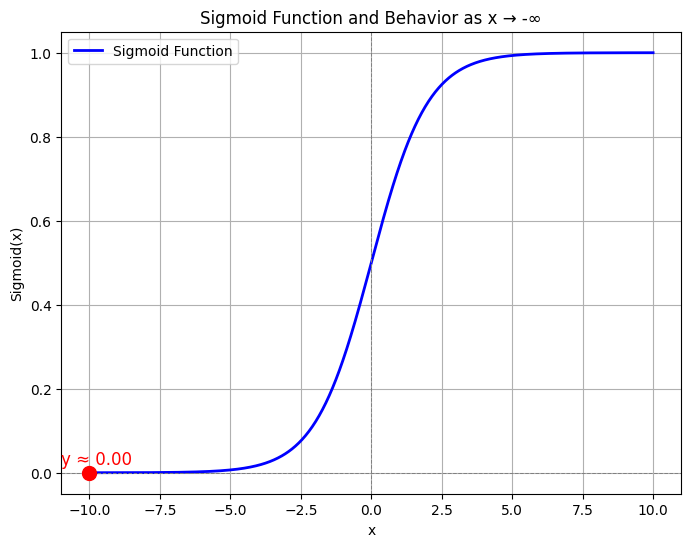

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid Function Definition
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate x values
x = np.linspace(-10, 10, 1000)  # Cover a wide range to approximate -inf and +inf
y = sigmoid(x)

# Highlight the point where x approaches -inf (effectively -10 here)
x_negative_infinity = -10  # Approximating -inf
y_negative_infinity = sigmoid(x_negative_infinity)

# Plot the Sigmoid function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label="Sigmoid Function", color="blue", linewidth=2)

# Highlight the point where x → -inf (y ≈ 0)
plt.scatter(x_negative_infinity, y_negative_infinity, color="red", s=100, zorder=5)
plt.text(x_negative_infinity - 1, y_negative_infinity + 0.02,
         f"y ≈ {y_negative_infinity:.2f}", color="red", fontsize=12)

# Add axis labels and title
plt.title("Sigmoid Function and Behavior as x → -∞")
plt.xlabel("x")
plt.ylabel("Sigmoid(x)")

# Add grid and legend
plt.axhline(0, color="gray", linestyle="--", linewidth=0.7)  # y = 0 line
plt.axvline(0, color="gray", linestyle="--", linewidth=0.7)  # x = 0 line
plt.legend()
plt.grid(True)

# Show the plot
plt.show()